Course Human-Centered Data Science ([HCDS](https://www.mi.fu-berlin.de/en/inf/groups/hcc/teaching/winter_term_2020_21/course_human_centered_data_science.html)) - Winter Term 2020/21 - [HCC](https://www.mi.fu-berlin.de/en/inf/groups/hcc/index.html) | [Freie Universität Berlin](https://www.fu-berlin.de/)
***
# A2 - Reproducibility Workflow


## Step 1️⃣: Data acquisition
In order to measure Wikipedia traffic from January 2008 until October 2020, you will need to collect data from two different APIs:

1. The **Legacy Pagecounts API** ([documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Legacy_Pagecounts), [endpoint](https://wikimedia.org/api/rest_v1/#!/Pagecounts_data_(legacy)/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end)) provides access to desktop and mobile traffic data from December 2007 through July 2016.
1. The **Pageviews API** ([documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews), [endpoint](https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end)) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month.

For each API, you need to collect data for all months where data is available and then save the raw results into five (3+2) separate `JSON`files (one file per API query type) before continuing to step 2.

To get you started, you can use the following **sample code for API calls**:

In [1]:
# Source: https://public.paws.wmcloud.org/User:Jtmorgan/data512_a1_example.ipynb?format=raw

import json
import requests

endpoint_legacy = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
endpoint_pageviews = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

legacy_parameters = {"project" : "en.wikipedia.org",
                 "access-site" : "desktop-site",
                 "granularity" : "monthly",
                 "start" : "2001010100",
                 "end" : "2018100100"
                    }

legacy_accesstypes = ["desktop-site", "mobile-site"]

pageview_parameters = {"project" : "en.wikipedia.org",
                    "access" : "",
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2001010100",
                    "end" : '2018101000'
                        }

pageview_accesstypes = ["desktop", "mobile-app", "mobile-web"]

headers = {
    'User-Agent': 'https://github.com/lukaskaibel',
    'From': 'lukas.kaibel@fu-berlin.de'
}


def api_call(endpoint,parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

In [2]:
def get_start_and_end(data):
    start = get_timestamp_for(0, data) [:-4] #returns the first month
    end = get_timestamp_for(-1, data) [:-4] 
    return (start, end)

def get_timestamp_for(index, data):
    return data["items"][index]["timestamp"]

def create_json_file(data, prefix):
    start_end = get_start_and_end(data)
    filename = prefix + "_" + start_end[0] + "_" + start_end[1] + ".json"

    with open(filename, "w") as outfile:
        json.dump(data, outfile)

In [3]:
#creates all legacy json files 
for accesstype in legacy_accesstypes:
    legacy_parameters["access-site"] = accesstype
    data = api_call(endpoint_legacy, legacy_parameters)
    filename = "legacy_" + accesstype
    create_json_file(data, filename)

    
#creates all pageviews json files 
for accesstype in pageview_accesstypes:
    pageview_parameters["access"] = accesstype
    data = api_call(endpoint_pageviews, pageview_parameters)
    user_data = [x for x in data["items"] if x["agent"] == "user"]   # filters agent = user
    filename = "pageviews_" + accesstype
    create_json_file(data, filename)

Your `JSON`-formatted source data file must contain the complete and un-edited output of your API queries. The naming convention for the source data files is: `apiname_accesstype_firstmonth-lastmonth.json`. For example, your filename for monthly page views on desktop should be: `pagecounts_desktop-site_200712-202010.json`

### Important notes❗
1. As much as possible, we're interested in *organic* (user) traffic, as opposed to traffic by web crawlers or spiders. The Pageview API (but not the Pagecount API) allows you to filter by `agent=user`. You should do that.
1. There is about one year of overlapping traffic data between the two APIs. You need to gather, and later graph, data from both APIs for this period of time.

## Step 2: Data processing

You will need to perform a series of processing steps on these data files in order to prepare them for analysis. These steps must be followed exactly in order to prepare the data for analysis. At the end of this step, you will have a single `CSV`-formatted data file `en-wikipedia_traffic_200712-202010.csv` that can be used in your analysis (step 3) with no significant additional processing.

* For data collected from the Pageviews API, combine the monthly values for `mobile-app` and `mobile-web` to create a total mobile traffic count for each month.
* For all data, separate the value of `timestamp` into four-digit year (`YYYY`) and two-digit month (`MM`) and discard values for day and hour (`DDHH`).

Combine all data into a single CSV file with the following headers:

| year | month |pagecount_all_views|pagecount_desktop_views|pagecount_mobile_views|pageview_all_views|pageview_desktop_views|pageview_mobile_views|
|------| ------|-------------------|-----------------------|----------------------|------------------|----------------------|---------------------|
| YYYY | MM    |num_views          |num_views              |num_views             |num_views         |num_views             |num_views            | 

In [190]:
def set_timestamps_to_monthly(data):
    timestamp = data["timestamp"].str[:-4]
    data["year"] = timestamp.str[:4]
    data["month"] = timestamp.str[-2:]
    del data["timestamp"]
    return data

In [206]:
def get_dataframe_for_json(filename):
    with open(filename) as json_file:
        json_data = json.load(json_file)
        df = pd.json_normalize(json_data, ["items"])
    #delete irrelevant columns
    del df["project"]
    del df["granularity"]
    if "access" in df:
        del df["access"]
    if "agent" in df:
        del df["agent"]
    if "access-site" in df:
        del df["access-site"]
    return df


In [218]:
import pandas as pd 

legacy_mobile = get_dataframe_for_json("legacy_mobile-site_201410_201608.json")
legacy_mobile.rename(columns={"count" : "pagecount_mobile_views"}, inplace=True)
legacy_mobile = set_timestamps_to_monthly(legacy_mobile)

legacy_desktop = get_dataframe_for_json("legacy_desktop-site_200712_201608.json")
legacy_desktop.rename(columns={"count" : "pagecount_desktop_views"}, inplace=True)
legacy_desktop = set_timestamps_to_monthly(legacy_desktop)


pageviews_mobile_app = get_dataframe_for_json("pageviews_mobile-app_201507_201809.json")
pageviews_mobile_web = get_dataframe_for_json("pageviews_mobile-web_201507_201809.json")  
pageviews_mobile_app = set_timestamps_to_monthly(pageviews_mobile_app)
pageviews_mobile_web = set_timestamps_to_monthly(pageviews_mobile_web)

#merging mobile-web and mobile-app
pageviews_mobile = pd.merge(pageviews_mobile_app, pageviews_mobile_web, on=["year", "month"])
pageviews_mobile["views"] = pageviews_mobile.loc[:,["views_x", "views_y"]].sum(axis=1)
del pageviews_mobile["views_x"]
del pageviews_mobile["views_y"]
pageviews_mobile.rename(columns={"views" : "pageview_mobile_views"}, inplace=True)

pageviews_desktop = get_dataframe_for_json("pageviews_desktop_201507_201809.json")
pageviews_desktop.rename(columns={"views" : "pageview_desktop_views"}, inplace=True)
pageviews_desktop = set_timestamps_to_monthly(pageviews_desktop)

In [221]:
overall_legacy_traffic = pd.merge(legacy_desktop, legacy_mobile, on=["year", "month"], how="outer")
overall_pageviews_traffic = pd.merge(pageviews_mobile, pageviews_desktop, on=["year", "month"], how="outer")
overall_traffic = pd.merge(overall_legacy_traffic, overall_pageviews_traffic, on=["year", "month"], how="outer")
overall_traffic.set_index(["year"])
overall_traffic["pagecount_all_views"] = overall_traffic.loc[:,["pagecount_desktop_views", "pagecount_mobile_views"]].sum(axis=1)
overall_traffic["pageview_all_views"] = overall_traffic.loc[:,["pageview_desktop_views", "pageview_mobile_views"]].sum(axis=1)

overall_traffic = overall_traffic[["year", "month", "pagecount_all_views", "pagecount_desktop_views", "pagecount_mobile_views", "pageview_all_views", "pageview_desktop_views", "pageview_mobile_views"]]
overall_traffic.to_csv("en-wikipedia_traffic_200712-202010.csv")

## Step 3: Analysis

For this assignment, the "analysis" will be fairly straightforward: you will visualize the dataset you have created as a **time series graph**. Your visualization will track three traffic metrics: mobile traffic, desktop traffic, and all traffic (mobile + desktop). In order to complete the analysis correctly and receive full credit, your graph will need to be the right scale to view the data; all units, axes, and values should be clearly labeled; and the graph should possess a legend and a title. You must also generate a .png or .jpeg formatted image of your final graph.
Please graph the data in your notebook, rather than using an external application!

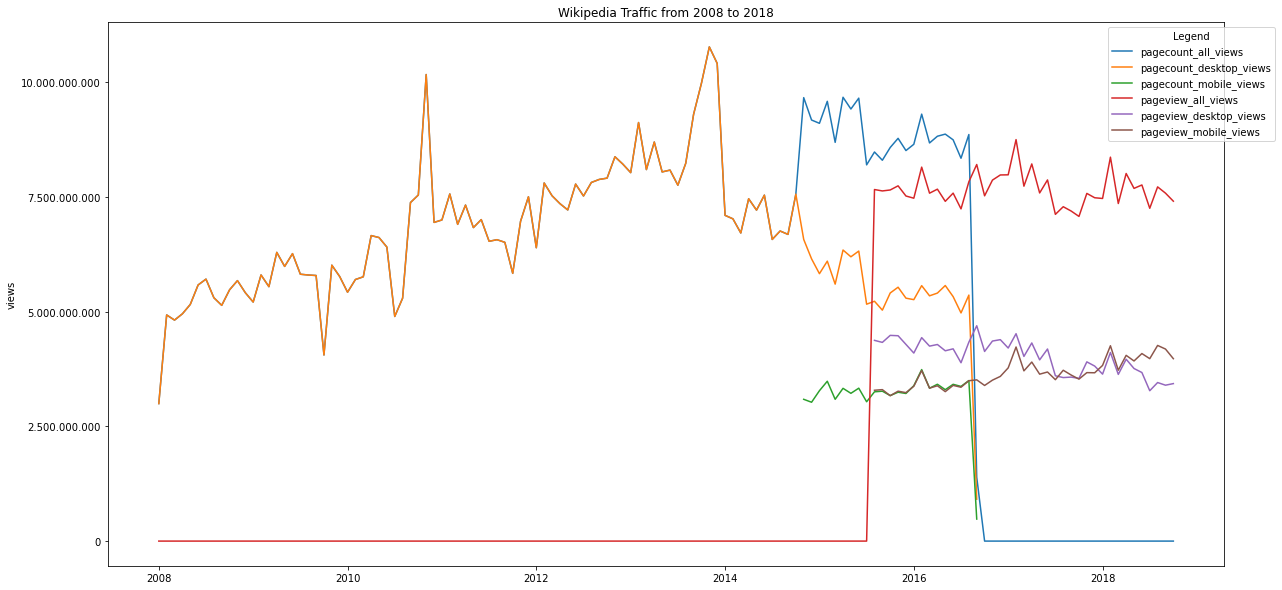

In [273]:
import matplotlib.pyplot as plt

data = pd.read_csv("en-wikipedia_traffic_200712-202010.csv")

plt.figure(figsize=(20,10))

plt.plot(data["year"] + 1/12 * data["month"], data["pagecount_all_views"])
plt.plot(data["year"] + 1/12 * data["month"], data["pagecount_desktop_views"])
plt.plot(data["year"] + 1/12 * data["month"], data["pagecount_mobile_views"])
plt.plot(data["year"] + 1/12 * data["month"], data["pageview_all_views"])
plt.plot(data["year"] + 1/12 * data["month"], data["pageview_desktop_views"])
plt.plot(data["year"] + 1/12 * data["month"], data["pageview_mobile_views"])

plt.legend(["pagecount_all_views", "pagecount_desktop_views", "pagecount_mobile_views", "pageview_all_views", "pageview_desktop_views", "pageview_mobile_views"], bbox_to_anchor=(1.05, 1), title="Legend")

plt.title("Wikipedia Traffic from 2008 to 2018")
plt.ylabel("views")

plt.yticks([0, 2500000000, 5000000000, 7500000000, 10000000000], [0, "2.500.000.000", "5.000.000.000", "7.500.000.000", "10.000.000.000"])
plt.savefig("en-wikipedia_traffic_200712-202010.png")

***

#### Credits

This exercise is slighty adapted from the course [Human Centered Data Science (Fall 2019)](https://wiki.communitydata.science/Human_Centered_Data_Science_(Fall_2019)) of [Univeristy of Washington](https://www.washington.edu/datasciencemasters/) by [Jonathan T. Morgan](https://wiki.communitydata.science/User:Jtmorgan).

Same as the original inventors, we release the notebooks under the [Creative Commons Attribution license (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/).